# This version focuses on "Violent Crimes" and "Property Crimes" as designated by Federal Bureau of Investigation's (FBI) National Incident-Based Reporting System (NIBRS). Uniform Crime Reporting (UCR) Program.

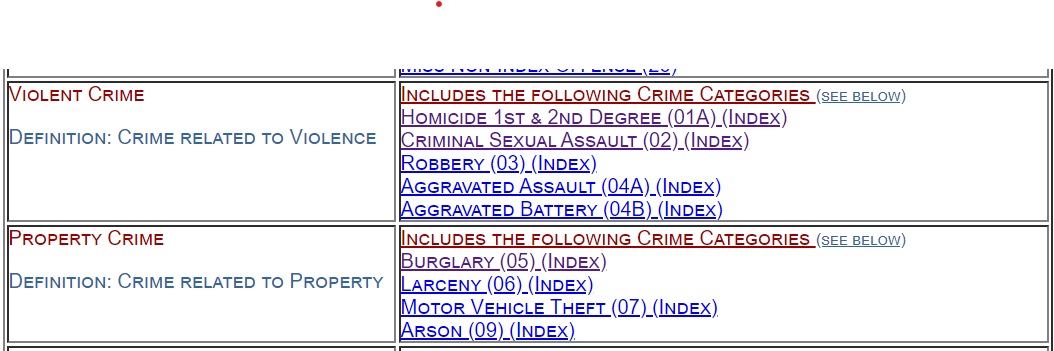

## Introduction

Chicago has frequently made the news for its high murder rate and gun violence, including being admonished by the Trump Administration in 2017.  However, overall crime and homicides decreased year over year, making the city safer today despite what various news sources report. 

This project analyzes reported crimes across Chicago, from 2003 through 2018.  The readers of this report will be able to understand the following upon completion:

### 1. Is Chicago safer today in their respective neighborhood?
### 2. Where do the majority of crimes (both violent and non-violent) occur, by neighborhood?
### 3. Has gun violence increased or decreased?
### 4. Where Violent or Property crimes may occur?  CLUSTERING
### 5. What factors such as location, date, even 'Arrest' would contribute to a crime being violent or property related?  "Use Random Forest"


## Dataset

I acquired this dataset from Chicago Data Portal: 

**https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g**

There are 22 features (mostly of a categorical nature) with 5.7 million records, each one representing a single reported crime from 2003 through 2018.  

### Brief Description of some of the variables:

* ID / Case Number - unique identifiers of the reported instance of crime

* Date / Year - two different date features representing when the incident occurred (best estimate)

* Block - Address with just the first 3 digits (rest redacted), and a direction along with street; Chicago operates on a grid system, therefore all streets have one of the following - N, S, E, W

* IUCR / FBI Code - Illinois Uniform Crime Reporting Codes and FBI Codes for categories of crime

* Primary Type / Description - categorical values of the incident.Example: **Homicide** to Primary Type, and **Handgun** to Description

* Location Description - Residence, Apartment, Street...

* Arrest - Binary of Yes/No

* Beat / District - Police Beat and one of the 25 Districts within Chicago

* Ward / Community Area - Chicago has 50 Wards and 77 Community Areas

* X / Y Coordinates / Latitude / Longitude - All Location variables


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import datetime
import time
import pyarrow
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [ ]:
crimes = pd.read_csv(('Crimes_-_2001_to_present.csv.xz'))

In [ ]:
crimes

## Data Cleaning

The dataset does not have complete information for years **2001, 2002, and 2019**, and I will remove records from those periods.  
Other features cannot be converted until the **NaN and Null** values have been removed.  As shown below, there are only 2 features with NaN values comprising over 1% of the entire dataset - **Ward** and **Community Area**.  Since Ward and Community Area NaN values are still less than 10% of the entire dataset, AND are **categorical values**,  I am choosing to drop those records.

### Features that will be converted OR dropped:

1. ID / Case Number / IUCR / Beat / FBI Code /Block / Domestic / X Coordinate / Y Coordinate / Updated On / Location - **DROPPED**
2. Date - from string to **datetime**
3. District / Ward / Community Area - from float to **integer**


## Feature Conversion

In [ ]:
crimes.head()

In [ ]:
crimes.isnull().sum()*100/crimes.isnull().count()

In [ ]:
crimes = crimes[crimes.Year != 2001]
crimes = crimes[crimes.Year != 2002]
crimes = crimes[crimes.Year != 2019]

In [ ]:
crimes.Year.unique()

In [ ]:
crimes = crimes.dropna()

In [ ]:
crimes.isnull().sum() #There are zero null or NaN values, and now specific features can be modified

### District / Ward / Community Area - from float to integer

In [ ]:
crimes.District = crimes.District.astype(int)
crimes.Ward = crimes.Ward.astype(int)
crimes['Community Area'] = crimes['Community Area'].astype(int)

# Crime Classification 

## Violent or Property

## Handgun or No Gun

## Homicide or No Homicide


In [ ]:
#Create a feature for Violent_Property, based on the Primary Type Descriptions



def viol_prop(x):
    
    if x == 'HOMICIDE' or x == 'CRIM SEXUAL ASSAULT' or x == 'ROBBERY' or x == 'ASSAULT' or x == 'BATTERY':
        return "Violent"
    elif x == 'BURGLARY' or x== 'THEFT' or x == 'MOTOR VEHICLE THEFT' or x == 'ARSON':
        return "Property"
    else:
        return "Other"
    
    
crimes['Is_Violent_or_Is_Property'] = crimes['Primary Type'].apply(viol_prop)

In [ ]:
#Drop the Other Crimes as they are not relevant for this model

In [ ]:
crimes = crimes[crimes.Is_Violent_or_Is_Property != 'Other']

crimes.Is_Violent_or_Is_Property.value_counts()

### Date Modification

Currently, 'Date' is a string.  

1. I will convert to timestamp
2. I am then created 3 new featuresr
    a. The specific hour of the incident
    b. The specific day of the week of the incident
    c. The specific day of the month of the incident
    
Note: I chose to modify dates **after** separating out crimes as "Property" and "Violent"




In [ ]:
crimes['Date'] = pd.to_datetime(crimes['Date'])

In [ ]:
crimes['Crime_hour'] = crimes['Date'].apply(lambda x: x.hour)
crimes['Crime_day_of_week'] = crimes['Date'].apply(lambda x: x.dayofweek)
crimes['Crime_day_of_month'] = crimes['Date'].apply(lambda x: x.day)

In [ ]:
crimes.head(1)

In [ ]:
crimes.Crime_day_of_week.value_counts()

In [ ]:
# dummy_gun = pd.get_dummies(crimes.Gun_Involved)
# dummy_homicide = pd.get_dummies(crimes.Homicide)
dummy_violent = pd.get_dummies(crimes.Is_Violent_or_Is_Property)
dummy_arrest = pd.get_dummies(crimes.Arrest)

In [ ]:
crimes = pd.concat([crimes, dummy_violent], axis=1)
crimes = pd.concat([crimes, dummy_arrest], axis=1)

In [ ]:
crimes['Gun_Involved'] = crimes['Description'].apply(lambda x: 1 if 'HANDGUN' in x  else 0)
crimes['Homicide'] = crimes['Primary Type'].apply(lambda x: 1 if 'HOMICIDE' in x  else 0)
#crimes['Is_Violent_or_Is_Property'] = crimes['Primary Type'].apply(lambda x: 1 if 'Violent' in x  else 0)

In [ ]:
crimes.columns

In [ ]:
crimes_final = crimes[['Arrest', 'Beat', 'District', 'Ward', 'Community Area',
                      'Is_Violent_or_Is_Property', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month', 'Property',
                       'Violent', False, True, 'Gun_Involved', 'Homicide', 'Year']]

In [ ]:
crimes_final.head(1)

In [ ]:
crimes.Is_Violent_or_Is_Property.value_counts()/len(crimes)  

In [ ]:
crimes.Gun_Involved.value_counts()

In [ ]:
crimes.Homicide.value_counts()/len(crimes)

In [ ]:
crimes.Arrest.value_counts()/len(crimes)

# Data Exploration

In [ ]:
crimes_final.corr()

In [ ]:
crimes_final.Arrest.value_counts().plot.bar()  #Total arrests vs. no arrests.  
#This could explain why people feel that Chicago is crime-ridden especially if crimes appear unsolved

In [ ]:
crimes_final.Year.value_counts(sort=False).plot.bar(title = 'Crime trend 2003-2018')
plt.xlabel('Year')
plt.ylabel('Total Crimes')

In [ ]:
crimes_handguns = crimes.Description.str.contains('HANDGUN')

In [ ]:
 crimes.groupby(['Year', crimes_handguns]).size().plot.bar()
# crimes.groupby(['Year', crimes_handguns]).plot.bar()

## create bar chart showing trend in homicides, violent crimes, and property crimes by year

In [ ]:
homicide_year.first()

# Modeling

## Undersampling or Oversampling to compensate for imbalance I'm NOT DOING IT!!!



## Decision Tree - What factors such as location, date, even 'Arrest' would contribute to a crime being violent or property related?

In [ ]:
crimes_final.Property.value_counts()
#crimes.Violent.value_counts()

In [ ]:
crimes_final.head(1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz


In [ ]:
#Based on time and location, can we predict if a crime is violent or property based?
X = crimes_final[['Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month']]
y = crimes_final.Violent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 9,
    max_depth = 2,
    random_state = 1337
)
dt.fit(X_train, y_train)

In [ ]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Property Crime', 'Violent Crime'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
predictions = dt.predict(X_test)

In [ ]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

In [ ]:
#Based on time and location, can we predict if a crime is violent or property based?
X = crimes_final[['Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_hour', 'Crime_day_of_week', 'Crime_day_of_month']]
y = crimes_final.Violent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 4,
    max_depth = 3,
    random_state = 1337
)
dt.fit(X_train, y_train)

In [ ]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Property Crime', 'Violent Crime'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
predictions = dt.predict(X_test)

In [ ]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

In [ ]:
confusion_matrix(y_test, predictions)

## Random Forest - What factors such as location, date, even 'Arrest' would contribute to a crime being violent or property related?

In [ ]:
X_train.head(1)

In [ ]:
from sklearn import ensemble


rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion= 'entropy',min_samples_split = 10, min_samples_leaf = 2,     
                                     max_features = 9)

rfc.fit(X_train, y_train)

In [ ]:
cross_val_score(rfc, X, y, cv = 5)

In [ ]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rfc.feature_importances_}).\
sort_values('importance', ascending = False)

In [ ]:
fi

In [ ]:
fi.plot.pie(y='importance', figsize = (10,10))
plt.legend(fi.feature)

## Clustering- Where Violent or Property crimes may occur?

In [ ]:
y